In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
from autoplan.generator import ProgramGenerator
from grammars.pythagorean.program import Program, PythagoreanLabels
from autoplan.dataset import build_synthetic_dataset
from autoplan.trainer import ParserTrainer
from autoplan.parsing import ProgramParser
from autoplan.token import JavaTokenizer
from tqdm import tqdm_notebook as tqdm
import torch
import pandas as pd
from pprint import pprint

device = torch.device('cpu')
#device = torch.device('cuda:0')

In [33]:
program_grammar = Program()
generator = ProgramGenerator(grammar=program_grammar)
program, choices, choice_options = generator.generate()
print(program)
pprint(choices)
pprint(choice_options)


            public class PythagoreanTheorem extends ConsoleProgram {
                public void run() {
                    
        println("Enter values to compute the Pythagorean Theorem.");
        double a = readDouble("a:");
        double b = readDouble("b:");
        double c = Math.sqrt(a * a + b * b);
        println("The answer is" + c);
        
                }
            }
        
[('START', 0),
 ('naming_scheme', 0),
 ('num_type', 1),
 ('print_function', 0),
 ('main_prompt', 0),
 ('input_prompt', 0),
 ('uses_method', 1),
 ('output_prompt', 2)]
{'START': [(1.0, None)],
 'input_prompt': [(0.5555555820465088, ''),
                  (0.2222222238779068, 'Enter '),
                  (0.1111111119389534, 'enter value '),
                  (0.1111111119389534, 'Enter value for ')],
 'main_prompt': [(0.699999988079071,
                  'Enter values to compute the Pythagorean Theorem.'),
                 (0.15000000596046448,
                  'This program finds the hypot

In [19]:
dataset = build_synthetic_dataset(
    N_train=1000, 
    N_val=100, 
    tokenizer=JavaTokenizer(),
    generator=ProgramGenerator(grammar=program_grammar))

'''
N_train = 1000 is when we reach 71-75% accuracy (maximum so far) and we don't get the accuracy decrease
on loops 12.5-15.0. Bigger batches (N_train = 10000) seem to hurt accuracy
'''

In [28]:
dataset.train_dataset[0]

{'program': tensor([ 0,  1,  2,  3,  4,  5,  0,  6,  7,  8,  9,  5, 10,  8, 11,  9, 12, 13,
         14, 15, 16,  8, 11,  9, 12, 13, 17, 15, 16,  8, 11,  9, 12, 13, 18, 15,
         19, 20, 21,  8, 14, 22, 14, 23, 17, 22, 17,  9, 12, 10,  8, 11, 23, 18,
          9, 12, 24, 24]),
 'trace': tensor([0, 1, 2, 3, 4, 5, 6, 7]),
 'choices': tensor([0, 0, 1, 0, 0, 3, 1, 0])}

In [29]:
batch = next(iter(dataset.loader(dataset.val_dataset)))

In [30]:
trainer = ParserTrainer(program_grammar, dataset, device)

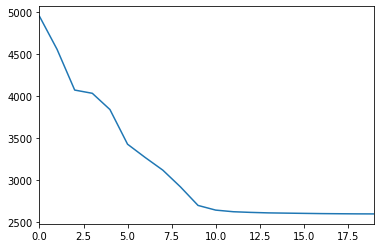

In [23]:
losses = []
accuracy = []
for _ in tqdm(range(20)):
    losses.append(trainer.train_one_epoch())
    accuracy.append(trainer.eval())
pd.Series(losses).plot()

[0.5042857142857143, 0.5857142857142857, 0.5957142857142858, 0.5914285714285714, 0.6642857142857143, 0.6571428571428571, 0.6742857142857143, 0.6657142857142857, 0.6985714285714286, 0.7014285714285714, 0.7114285714285714, 0.7057142857142857, 0.71, 0.7057142857142857, 0.7014285714285714, 0.7057142857142857, 0.7028571428571428, 0.7028571428571428, 0.7028571428571428, 0.7057142857142857]


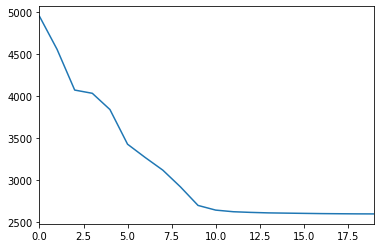

In [24]:
pd.Series(losses).plot()
print(accuracy)

In [25]:
trainer.model.save('checkpoint.ph.tar')

In [26]:
parser = ProgramParser(program_grammar, dataset, 'checkpoint.ph.tar', device)

In [27]:
parser.infer(batch['program'][:1], batch['program_len'][:1])

OrderedDict([('START', (0, None)),
             ('naming_scheme', (0, 'a')),
             ('num_type', (0, 'int')),
             ('print_function', (0, 'println')),
             ('main_prompt',
              (0, 'Enter values to compute the Pythagorean Theorem.')),
             ('input_prompt', (0, '')),
             ('uses_method', (0, True)),
             ('output_prompt', (1, 'c:'))])